# Benchmark

This benchmark will compare these solvers and their variant:
- Brute Force (Time limit sets to 100 seconds)
- Gurobi (Time limit sets to 10 seconds)
- Gurobi (Time limit sets to 100 seconds)
- Fixstars (Time limit sets to 10 seconds)

The benchmark will run on these specifications:
- $n \in (4, 5, 6, 7, 8, 10, 12, 15, 20, 42, 69)$
- Constraint weight set to 1000, 1000000, 1000000000
- Each test will be run 3 times, total test would be 3\*3\*11 = 99 runs

In [1]:
import json
from pprint import pprint

with open('result.json') as f:
    data = json.load(f)
    
pprint(data[0])

{'avg_edge_weight': 3.0,
 'constraint_weight': 15000000,
 'distance_matrix': [[0, 6, 5, 1], [6, 0, 3, 2], [5, 3, 0, 7], [1, 2, 7, 0]],
 'max_edge_weight': 7,
 'nodes': 4,
 'solvers_results': [{'execution_time': 0.0,
                      'name': 'Brute Force',
                      'objective': 11,
                      'total_time': 0.0},
                     {'execution_time': 0.118,
                      'name': 'Gurobi 10s',
                      'objective': 11.0,
                      'total_time': 0.2207930088043213},
                     {'execution_time': 0.009999,
                      'name': 'Gurobi 100s',
                      'objective': 11.0,
                      'total_time': 0.012177705764770508},
                     {'execution_time': 0.043228,
                      'name': 'Fixstars 1s',
                      'objective': 11.0,
                      'total_time': 3.401531457901001},
                     {'execution_time': 0.037757,
                      'name': 'F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

### Success Count by Solver vs $n$

D-Wave starts to fail at $n$ = 7, while Fixstars and Gurobi can still solve the problem.

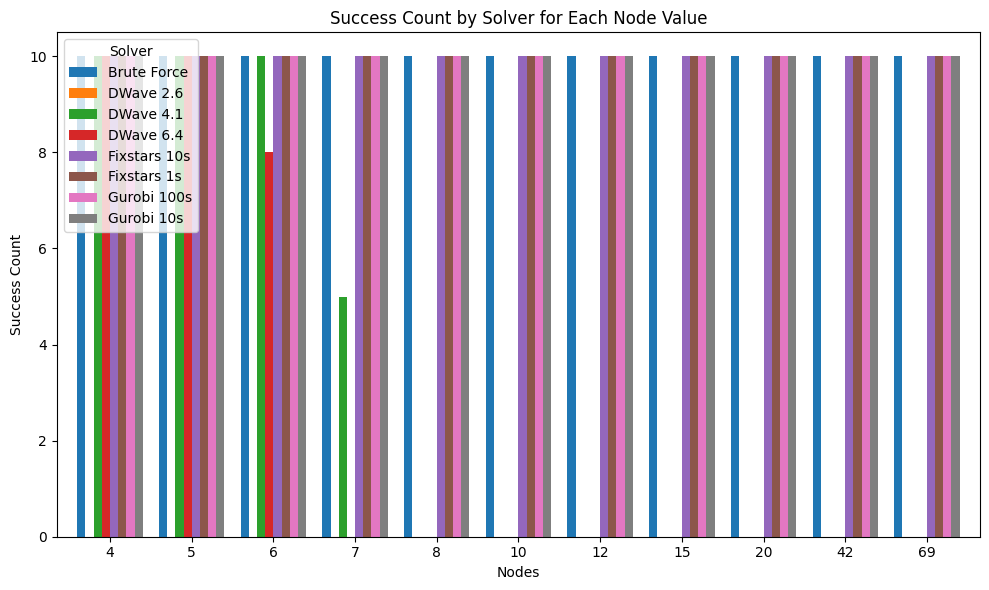

In [3]:
# Prepare data for plotting
records = []
for item in data:
    nodes = item["nodes"]
    for solver in item["solvers_results"]:
        success = solver["objective"] is not None and solver["execution_time"] is not None
        records.append({"nodes": nodes, "solver": solver["name"], "success": int(success)})

# Convert to DataFrame
df = pd.DataFrame(records)

# Group by nodes and solver to count successes
success_counts = df.groupby(["nodes", "solver"]).sum().reset_index()

# Pivot data for plotting
pivot_data = success_counts.pivot(index="nodes", columns="solver", values="success").fillna(0)

# # Ensure legend order
# solver_order = ["Brute Force", "Gurobi 10s", "Gurobi 1000s", "Fixstars", "D-Wave"]
# pivot_data = pivot_data[solver_order]

# Plot multi-bar chart
pivot_data.plot(kind="bar", figsize=(10, 6), width=0.8)
plt.title("Success Count by Solver for Each Node Value")
plt.xlabel("Nodes")
plt.ylabel("Success Count")
plt.legend(title="Solver", loc="upper left")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Success Count by Solver vs Constraint Weight

### Box and Whisker Plot of Execution time vs Nodes

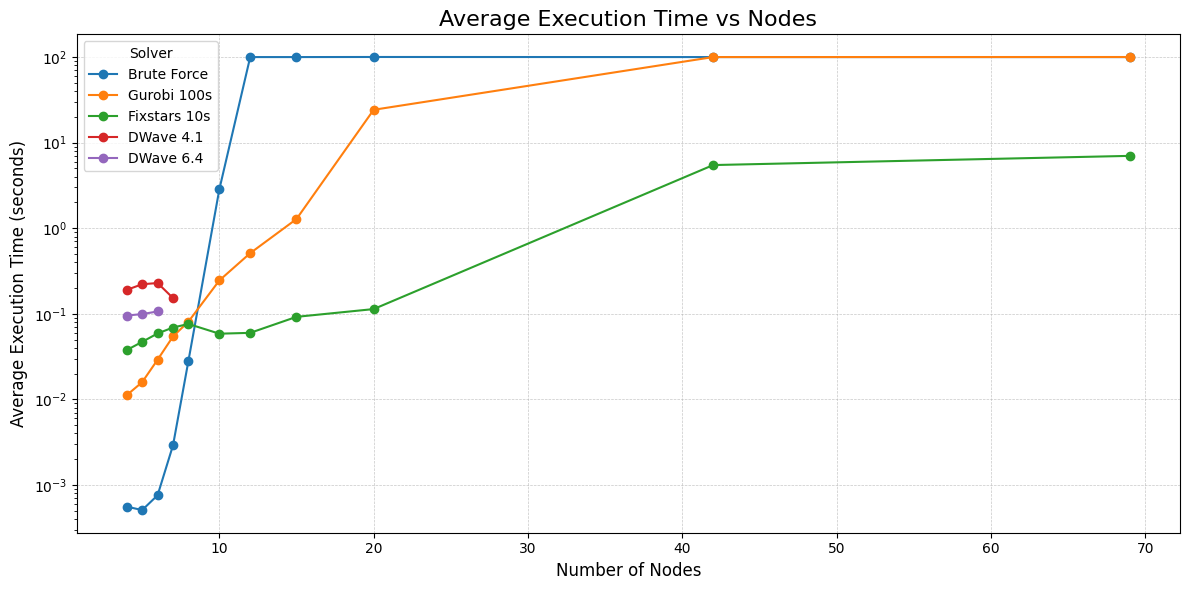

In [ ]:
# Prepare data for plotting
solver_names = ("Brute Force", "Gurobi 100s", "Fixstars 10s", "DWave 4.1", "DWave 6.4")
plot_data = []
for dataset in data:
    for result in dataset["solvers_results"]:
        if result["name"] in solver_names:
            plot_data.append({
                "nodes": dataset["nodes"],
                "solver": result["name"],
                "execution_time": result["execution_time"]
            })
df_plot = pd.DataFrame(plot_data)

brute_force_min = df_plot[(df_plot["solver"] == "Brute Force") & (df_plot["execution_time"] > 0)]["execution_time"].min()
df_plot.loc[(df_plot["solver"] == "Brute Force") & (df_plot["execution_time"] == 0), "execution_time"] = brute_force_min
# Calculate average execution time for each solver at each node count
avg_times = df_plot.groupby(["nodes", "solver"])["execution_time"].mean().reset_index()

# Plot the average execution time as a line graph
plt.figure(figsize=(12, 6))
for solver in solver_names:
    subset = avg_times[avg_times["solver"] == solver]
    plt.plot(
        subset["nodes"],
        subset["execution_time"],
        label=solver,
        marker="o"
    )

# Add labels, title, and legend
plt.title('Average Execution Time vs Nodes', fontsize=16)
plt.xlabel('Number of Nodes', fontsize=12)
plt.ylabel('Average Execution Time (seconds)', fontsize=12)
plt.legend(title="Solver", fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Use logarithmic scale for execution time
plt.yscale("log")

# Show the plot
plt.tight_layout()
plt.show()

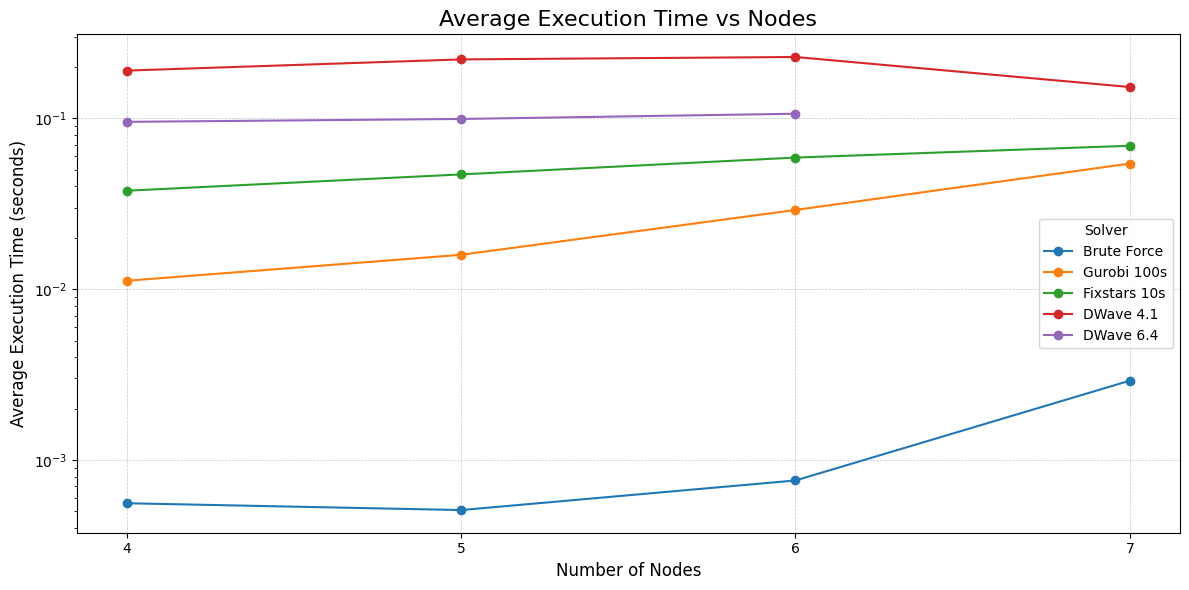

In [12]:

# Define solvers of interest
solver_names = ("Brute Force", "Gurobi 100s", "Fixstars 10s", "DWave 4.1", "DWave 6.4")

# Prepare data for plotting
plot_data = []
for dataset in data:
    for result in dataset["solvers_results"]:
        if result["name"] in solver_names and int(dataset["nodes"]) < 8:
            plot_data.append({
                "nodes": dataset["nodes"],
                "solver": result["name"],
                "execution_time": result["execution_time"]
            })
df_plot = pd.DataFrame(plot_data)

# Replace 0 values for 'Brute Force' with the minimum non-zero value
brute_force_min = df_plot[(df_plot["solver"] == "Brute Force") & (df_plot["execution_time"] > 0)]["execution_time"].min()
df_plot.loc[(df_plot["solver"] == "Brute Force") & (df_plot["execution_time"] == 0), "execution_time"] = brute_force_min

# Calculate average execution time for each solver at each node count
avg_times = df_plot.groupby(["nodes", "solver"])["execution_time"].mean().reset_index()

# Plot the average execution time as a line graph
plt.figure(figsize=(12, 6))
for solver in solver_names:
    subset = avg_times[avg_times["solver"] == solver]
    plt.plot(
        subset["nodes"],
        subset["execution_time"],
        label=solver,
        marker="o"
    )

# Add labels, title, and legend
plt.title('Average Execution Time vs Nodes', fontsize=16)
plt.xlabel('Number of Nodes', fontsize=12)
plt.ylabel('Average Execution Time (seconds)', fontsize=12)
plt.legend(title="Solver", fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Use logarithmic scale for execution time
plt.yscale("log")

# Set x-axis to display only integer node counts
plt.xticks(ticks=avg_times["nodes"].unique(), labels=avg_times["nodes"].unique())

# Show the plot
plt.tight_layout()
plt.show()

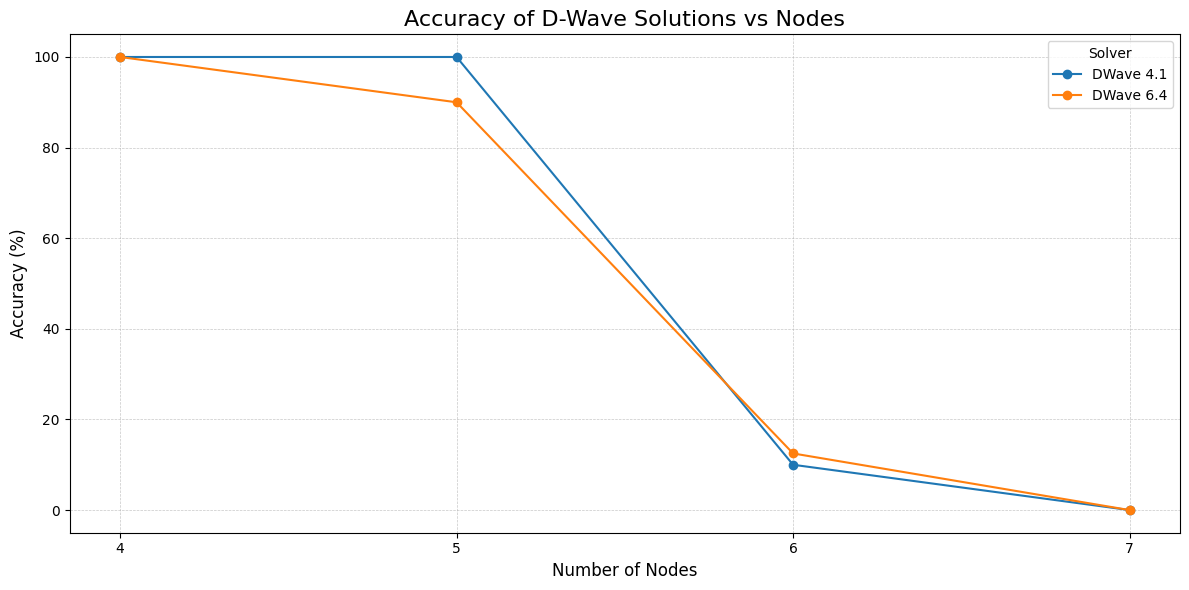

In [11]:
# Filter relevant data for Brute Force and quantum solvers
quantum_solvers = ["DWave 4.1", "DWave 6.4"]


data_filtered = {}
bruteforces = {}
for dataset in data:
    nodes = dataset["nodes"]
    if int(nodes) > 7:
        continue
    if nodes not in data_filtered:
        data_filtered[nodes] = {}
    for result in dataset["solvers_results"]:
        if result["name"] == "Brute Force" and result["objective"] is not None:
            bruteforces[nodes] = result["objective"]
            break
    for result in dataset["solvers_results"]:
        if result["name"] in quantum_solvers and result["objective"] is not None:
            if data_filtered[nodes].get(result["name"]) is None:
                data_filtered[nodes][result["name"]] = [result["objective"] - bruteforces[nodes]]
            else:
                data_filtered[nodes][result["name"]].append(result["objective"] - bruteforces[nodes])


# Calculate accuracy
accuracy = {}
for nodes, solvers in data_filtered.items():
    accuracy[nodes] = {}
    for solver, results in solvers.items():
        correct = sum(1 for x in results if x == 0)  # Count correct results
        total = len(results)  # Total results
        accuracy[nodes][solver] = (correct / total) * 100  # Accuracy percentage

# Prepare data for plotting
nodes = sorted(accuracy.keys())
solver_names = set(solver for solvers in data_filtered.values() for solver in solvers.keys())
plot_data = {solver: [accuracy[node].get(solver, 0) for node in nodes] for solver in solver_names}

# Plot
plt.figure(figsize=(12, 6))
for solver, acc_values in plot_data.items():
    plt.plot(nodes, acc_values, label=solver, marker="o")

# Add labels, title, and legend
plt.title('Accuracy of D-Wave Solutions vs Nodes', fontsize=16)
plt.xlabel('Number of Nodes', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks(nodes)  # Show only integer node counts
plt.legend(title="Solver", fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Show plot
plt.tight_layout()
